In this lecture, we study text similarities and distances. Speicifcally we focus on word mover distance (WMD). 

We always need to compute similarity in meaning between texts. For example, in search engines, we often need to model the relevance of a document to a query. For example, sites like Quora or Stackoverflow need to determine whether a question has already been asked before. In legal matters, text similarity tasks allow us to mitigate risks on new contracts, based on the assumption that if a new contract is similar to an existant one that has been proved to be resilient, the risk of this new contract being the cause of financial loss is minimized. Automatic linking of related documents therefore becomes really important. In customer services, AI systems should be able to understand semantically similar queries from users and provide a uniform response. The emphasis on semantic similarity aims to create a system that recognizes word patterns to craft responses that are similar to how a human conversation works.

Essentially text similarity has to determine how 'close' two pieces of texts are in surface closeness (**lexical similarity**) and meaning (**semantic similarity**). We have studied word similarities previously, and the focus of this mini-lecture is on phrase/sentence similarity level (text similarity in general). This is a big topic and we will not go over all methods. Majority of the most state-of-the-art methods for measuring text similarity is based on deep learning. Here are some of the posh methods to measure text similarities:

   - word embeddings + variational autoencoders (VAEs)
   - word embeddings + universal sentence encoders (USEs)
   - word embeddings + Siamese Manhattan LSTM
   - BERT embeddings + cosine similarity 
   - Knowledge-based measures (e.g. WordNet)

We will actually not go over any methods mentioned above in the rest of the tutorial, as they require more advanced deep learning network structures; we will certainly go over them in the future. But notice that majority of these require different kinds of embeddings. We have studied word embeddings. However, there are different types of embeddings, such as sentence embeddings as well. Take the aforementioned USEs as an example, there are researchers that find transfer learning using sentence embeddings tends to outperform word level transfers. These models are trained and optimized for greater-than-word length texts, such as sentences, phrases or paragraphs. This type of embedding is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of NLP taasks. The input is variable-length English text and the output is a 512-dimensional vector. Several such encoders are available:

   - InferSent (Facebook Research): this encoders uses bidirectional LSTM model with max pooling, trained on the SNLI dataset. SNLI is the Stanford Natural Language Inference Corpus (see here: https://nlp.stanford.edu/projects/snli/). 
   - Google Sentence Encoder: this is a simpler deep averaging network (DAN) where input embeddings for words and bigrams are averaged together and passed through a feed-forward deep neural network. 

All these topics involve some advanced deep learning techniques. Here, we will only focus on the extension of the word embedding: word mover distance (WMD). This method is very off-the-shelves in nature compared to the 5 previously mentioned methods. 

Before we talk about WMD, let's first review some old-school way of measuring text similarities or dissimilarities. 


In [6]:
import numpy as np
import pandas as pd
import nltk
import gensim
import os 
import PyEMD 
import logging

import gensim.downloader as api

from IPython.display import Image
from PyEMD import emd # needing the 0.1.1 version, the 0.5.1 version will not be compatible with the the gensim 3.8.3 version for WMD
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
path="C:\\Users\\GAO\\python workspace\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

#path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
#os.chdir(path)

print('Gensim Version: ', gensim.__version__)
print('Earth Mover Distance Package Version (PyEMD): ', PyEMD.__version__)

Gensim Version:  3.8.3
Earth Mover Distance Package Version (PyEMD):  0.1.1


In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GAO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GAO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### I. Some Old Methods of Measuring Text Similarity

The oldest measure of text similarity is the **Jaccard similarity measure**. This metric essentially calculates the measures of intersection over union. Let's look at two sentences:

   1. AI is our friend and has been friendly.
   2. AI and humans have always been friendly.

To calculate the Jaccard similarity measure, we need to perform tokenization first. The words "friends" and "friendly" both have the same root, so we will treat them as one. Let's define the Jaccard similarity measure:


In [8]:
def jaccard_sim(query, doc):
    intersection=set(query).intersection(set(doc))
    union=set(query).union(set(doc))
    return len(intersection)/len(union)

Now let's calculate the Jaccard similarity:

In [9]:
s1=['ai', 'friend']
s2=['ai', 'humans', 'friend']
jaccard_sim(s1, s2)

0.6666666666666666

One immediately sees that this metric is very inflexible because if we have two sentneces sharing no common words or word root, then the metric will return 0. Suppose we run into a scenario like the following, we are in trouble:

   1. The President greeted the press in Chicago.
   2. Obama spoke in the largest city in Illinois.

The Jaccard metric will have a score of 0 using the two sentences above. This is because the metric is neither able to capture semantic similarity nor lexical semantic of these two sentences. 

A similar metric is the **cosine similarity measure**. Remember the cosine function in mathematics looks at the angle between two vectors. If $a, b$ are 2 vectors, with the angle in between them to be defined as $\theta$, then we define $\cos(\theta)=\frac{a \cdot b}{||a||||b||}$. The cosine similarity is advantagenous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are that they may still be oriented closer together under the cosine measure. However, cosine similarity suffers from a similar problem: it does not takes semantic meaning into account.

Let's see an example:

In [13]:
s1 ="I love horror movies"
s2 ="Lights out is a horror movie"
  
# tokenization
s1_list = word_tokenize(s1) 
s2_list = word_tokenize(s2)
  
# sw contains the list of stopwords
sw = stopwords.words('english') 
l1 =[]
l2 =[]

# removing stop words from the string
s1_set = {w for w in s1_list if not w in sw} 
s2_set = {w for w in s2_list if not w in sw}
  
# forming a set containing keywords of both strings 
rvector = s1_set.union(s1_set) 
for w in rvector:
    if w in s1_set: l1.append(1) # create a vector
    else: l1.append(0)
    if w in s2_set: l2.append(1)
    else: l2.append(0)
c = 0
  
# cosine formula 
for i in range(len(rvector)):
        c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print("Cosine similarity: ", cosine)

Cosine similarity:  0.5


To overcome the challenge of using existing metrics, we really need word embeddings. This is when the word mover distance (WMD) comes in handy. The foundation of WMD is earth mover's distance (EMD), so we will study EMD first.

### II. Mathematical Background of Earth Mover Distance (EMD)

Before we move onto discussing the WMD, first, we need to go to the Windows folder where we store the Python file named 'keydvector.py'. For example, the place where we stored our library can be found here:

   - C:\Users\GAO\.conda\envs\gao_uat\Lib\site-packages\gensim\models

Open up that 'py.' file, and the find the line where it says the following:

   - import pyemd

Then change that line to the following:

   - import PyEMD

This is because the package that implements the 'earth mover distance' has gone through a version change. We need the earth mover distance package 'PyEMD' to be on the 0.1.1 version; the 0.5.1 version will not be compatible with the the gensim 3.8.3 version for WMD. In other words, for this tutorial, here are the package version requirements:

   - Gensim: we need the 3.8.3 version
   - PyEMD: we need the 0.1.1 version


Let's first look at the intuition of WMD. Suppose we have two sentences:

   - Obama speaks to the media in Illinois.
   - The president greets the press in Chicago.

After removing the stopwords, we have:

   - Obama speaks media Illinois
   - president greets press Chicago

My sparse vectors for the 2 sentences have no common words, therefore we have a cosine distance of 0. In contrast, WMD uses the word embeddings of the words in two texts to measure the minimum distance that the words in one text need to 'travel' in some semantic space to reach the words in the other text. WMD comes from an original concept of earth mover's distance (EMD), which is a measure of the distance between 2 probability distributions over a region (known as the **Wasserstein metric**). Informally, if the distributions are interpreted as 2 different ways of piling up a certain amount of dirt over the region, the EMD is the miminum cost of turning one pile into the other, where the cost is assumed to be amount of dirt moved times the distance by which it is moved. So in order to understand what WMD is, we first need to understand the concept of EMD and Wasserstein metric. Below, we will review some real analysis concept for the EMD theory.

#### Definition:

   - A **Hausdorff space**, or a **separated space**, or **T2 space**, is a topological space where for any two distinct points there exist neighbourhoods of each, which are disjoint from each other. If $X$ is a topological space and $p$ is a point in $X$ s.t. $p \in X$, a neighbourhood of $p$, denoted by $\mathcal{N}(p)$, is a subset of $X$ that includes an open set $G$ containing $p$, that is, $p \in G \subseteq \mathcal{N}(p)$ where $G$ is an open set defined on the topology.
 
Of the many separation axioms that can be imposed on a topological space, the "Hausdorff condition" (T2) is the most frequently used and discussed. It implies the uniqueness of limits of sequences. It also implies the uniqueness of limits of **nets**, and **filters** in general topology. The meaning of Hausdorff really is implicit in many of our real analysis examples. Almost all spaces encountered in analysis are Hausdorff; most importantly, all metric spaces are Hausdorff. **Pseudometric spaces** (a generalization of metric spaces) typically are not Hausdorff. Unlike a metric space, points in a pseudometric space need not be distinguishable; that is, one may have $d(x,y)=0$ for distinct values $x \neq y$.

Below is what a Hausdorff space looks like:

In [14]:
mpath='http://mathonline.wdfiles.com/local--files/hausdorff-topological-spaces/Screen%20Shot%202015-09-28%20at%208.20.30%20AM.png'
Image(url=mpath)

#### Definition:

   - a **Borel set** is any set in a topological space that can be formed from open sets (or, equivalently, from closed sets) through the operations of countable union, countable intersection, and relative complement. The Borel $\sigma$-algebra is defined to be the $\sigma$-algebra generated by these open sets.

Borel sets are important in measure theory, since any measure defined on the open sets of a space, or on the closed sets of a space, must also be defined on all Borel sets of that space. Any measure defined on the Borel sets is called a Borel measure. Recall the definition of basic $\sigma$-algebra:

In [15]:
mpath='https://miro.medium.com/max/1400/1*ZQe5nIfuhvygYgyBl2jkmA.png'
Image(url=mpath, width=600, height=100)

#### Definition:

   - Let $X$ be a Hausdorff topological space. We say $X$ is **locally compact Hausdorff space** if every point $x \in X$  has a compact neighborhood. 

It's important to note that the definition of local compactness does not really depend on the space being Hausdorff, although it's often the case. Since majority of the topological spaces we are dealing with are Hausdorff, it greatly simplifies the definition of local compactness, as being Hausdorff really requires that these compact neighborhoods exist in a controlled way. Defining local compactness without being Hausdorff becomes fairly complicated. Details of this type of discussion can be found here: 

   - https://ncatlab.org/nlab/show/locally+compact+topological+space#:~:text=In%20particular%20every%20compact%20Hausdorff,compactification%20X%E2%8A%94%7B%E2%88%9E%7D. 

Obviously, every discrete space is locally compact. Every compact Hausdorff space itself is locally compact. The real numbers, complex numbers, the unit interval $[0,1]$, the Cantor sets etc. are locally compact. In contrast, the set of rational numbers is not locally compact. 

With these definitions, we can define Radon measures. The idea of Radon measure is to find a good notion of a measure on a topological space that is compatible with the topology in some sense. 

#### Definition:

   - Let $X$ be a locally compact Hausdorff topology induced by generic open sets like $G$. Let $\mu(.)$ be a generic measure in $X$ with the corresponding $\sigma$-algebra. Let $B$ be a generic Borel set and let $K$ be a compact set in this topology. Then:
      - We say that a measure is **inner regular** (or **tight**) iff for any Borel set $B$, $\mu(B)=sup_{K \subseteq B}\mu(K)$. 
      - We say that a measure is **outer regular** iff for any Borel set $B$, $\mu(B)=inf_{B \subseteq G}\mu(G)$. 
      - We say that a measure is **regular** iff it is both outer regular and inner regular.
      - We say a measure is **locally finite**  iff every point $x \in X$ has a neighborhood $\mathcal{N}(x)$ for which $\mu(\mathcal{N}(x))$ is finite.
   - In measure theory, a **Radon measure** $\mu(.)$ is a measure on the $\sigma$-algebra of Borel sets of a Hausdorff topological space $X$ that is locally finite on all compact sets, outer regular on all Borel sets, and inner regular on all open sets. 

Essentially, the inner regularity and outer regularity allow the measure of a set to be approximated by the measures of open sets from the outside or compact sets from the inside. An immediate example of a Radon measure is the Lebesgue measure defined on Euclidean space. 

#### Definition:

   - A Hausdorff space $X$ is called a **Radon space** if every finite Borel measure on $X$ is a Radon measure.

#### Definition:
   
   - In measure theory, a **push-forward measure (or image measure)**  is obtained by transferring (thus _pushing forward_) a measure from one measurable space to another using a measurable function. Given two measure spaces $(X_{1}, \Sigma_{1})$ and $(X_{2}, \Sigma_{2})$, where the sets $\Sigma_{1}, \Sigma_{2}$ denote the corresponding $\sigma$-alebras for the original sets, a measurable mapping $T: X_{1} \rightarrow X_{2}$ and a measure $\mu(.): \Sigma_{1} \rightarrow [0, \infty]$, the push-forward of $\mu$ is defined to be the measure $T \dagger \mu: \Sigma_{2} \rightarrow [0, \infty]$ given by $(T \dagger \mu)(S)=\mu(T^{-1}(S))$ for $S \in \Sigma_{2}$.

#### Definition:

   - A **Dirac measure** assigns a size to a set based solely on whether it contains a fixed element $x$ or not. In other words, a Dirac measure $\delta_{x}(S)=1$ if $x \in S$ and $\delta_{x}(S)=0$ if  $x \notin S$. 
   
A Dirac measure is a probability measure. And in terms of probability it represents the almost sure outcome $x$ in the sample space. 

With these definitions, we can start delving into WMD.

#### Definition:

   - Let $(M,d)$ be a metric space for which every Borel probability measure on $M$ is a Radon measure (so called Radon space). Let $U_{p}(M)$ denote the collection of all probability measures $\mu$  on $M$ with finite $p$-th moment. By definition, there exists a point $a$ s.t. $\int_{M}d^{p}(x,a)d\mu(x) < \infty$. For $p \ge 1$, the $p$-th Wasserstein distance betweeen 2 probability measures $\mu$ and $\nu$ in $U_{p}(M)$ is defined as $W_{p}(\mu, \nu)=(inf_{F \in J(\mu,\nu)} \int_{M \times M}d^{p}(x,y)dF(x,y))^{\frac{1}{p}}$, where $F$ denotes the joint CDF function and $ J(\mu,\nu)$ denotes the collection of all measures on $M \times M$ with marginals on the first and second factors respectively. This set is also called the set of all couplings of the two measures.

The mathematical definition of Wasserstein distance is quite complicated. To simplify the explanation, let's go back to the historical motivation of this metric. Suppose we have two random variables with their respective CDFs $X \sim F_{X}$ and $Y \sim F_{Y}$ and respective densities $f_{X}, f_{Y}$. Suppose both random variables are $K$-dimensional. We want to create the notion of distance between two distributions. There are several existing candidates:

   - Total Variation: $sup_{A}|F_{X}(A)-F_{Y}(A)|$ (the largest distance it can be)
   - Hellinger's distance: $\sqrt{\int(\sqrt{f_{X}(.)}-\sqrt{f_{Y}(.)})^{2}}$
   - L2 distance: $\int(f_{X}(.)-f_{Y}(.))^{2}$
   - $\chi^{2}$: $\int\frac{(f_{X}-f_{Y})^2}{f_{Y}}$

These distances are useful, but they have some drawbacks, for example:

   - We cannot use them to compare two distributions when one is discrete and the other is continuous. 
   - When we average different objects such as distributions or images, we would like to make sure that we get back a similar object. The existing metrics do not perform well.
   - When we compute the usual distance between 2 distributions, we get a number but we don't get any qualitative information about why the distributions differ. We will see that using Wasserstein distance, we can also get a map that shows us how we have to move the 'mass' of $X$ to morph it into $Y$.
   - Suppose we want to create a path of distributions (called a geodesic), denoted by $P_{t}$ that interpolates between 2 distributions $X$ and $Y$. We would like the distributions $P_{t}$ to preserve the basic structure of the distributions. It turns out that existing metrics do not perform well compared to Wasserstein distance. 
   - These existing distances ignore the underlying geometry of the space. Consider the picture below, we have three densities $p_{1}, p_{2}, p_{3}$. It is easy to see that using Hellinger's distance, the pairwise distances of these distributions are all the same, but our intuition tells us that $p_{1}, p_{2}$ should be closer. 

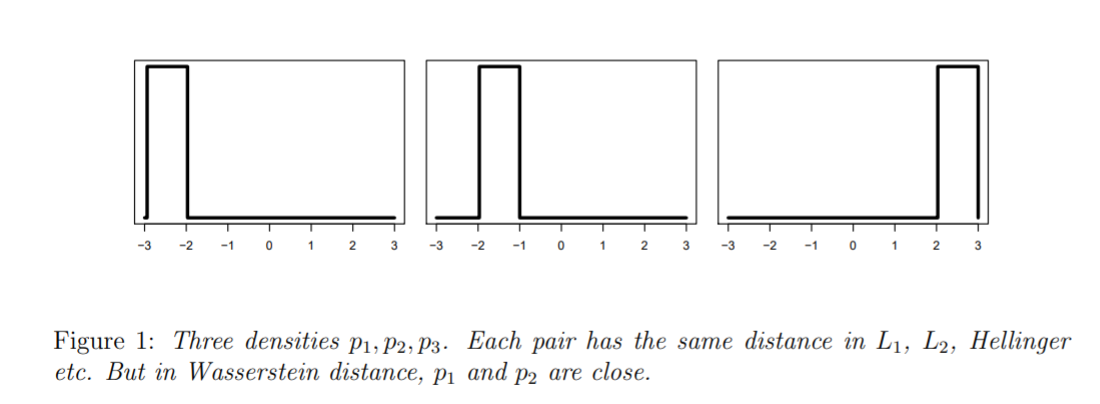

In [16]:
Image("probability distance.PNG")

The Wasserstein distance arises during the study of optimal transport problem while trying to address the imperfections of the metrics aforementioned, such as the Hellinger's distance. This is a big topic in real analysis and probability theory. The problem was formalized by the French mathematician Gaspard Monge in 1781. Major advances were made in the field during World War II by the Soviet mathematician and economist Leonid Kantorovich.

The original transportation problem can be formulated this way: suppose that we have a collection of $m$ mines mining iron ore, and a collection of $n$ factories which use the iron ore that the mines produce. Suppose for the sake of argument that these mines and factories form two disjoint subsets $M$ and $N$ of the Euclidean plane $\mathbb{R}^{2}$. Suppose also that we have a cost function $c : \mathbb{R}^{2} \times \mathbb{R}^{2} \rightarrow [0, \infty)$, so that $c(x, y)$ is the cost of transporting one shipment of iron from $x$ to $y$. For simplicity, we ignore the time taken to do the transporting. We also assume that each mine can supply only one factory (no splitting of shipments) and that each factory requires precisely one shipment to be in operation (factories cannot work at half- or double-capacity). Having made the above assumptions, a transport plan is a bijection $T : M \rightarrow N$. In other words, each mine $m \in M$ supplies precisely one target factory $T(m) \in N$ and each factory is supplied by precisely one mine. We wish to find the optimal transport plan, the plan $T(.)$ whose total cost can be minimized s.t. $c(T) = \sum_{m \in M}c(m, T(m))$ (the least of all possible transport plans from $M$ to $N$). This motivating special case of the transportation problem is an instance of the assignment problem. More specifically, it is equivalent to finding a minimum weight matching in a **bipartite graph** in graphy theory. A bipartite graph (or bigraph) is a graph whose vertices can be divided into two disjoint and independent sets $U, V$ such that every edge connects a vertex in $U$ to one in $V$. Below is an example of a **complete bipartite graph** (by complete, we mean every vertex of the first set is connected to every vertex of the second set):

In [17]:
mpath='https://i1.wp.com/algorithms.tutorialhorizon.com/files/2019/09/Bipartite-Graph-3.png?w=517&ssl=1'
Image(url=mpath)

The transportation problem as it is stated in modern or more technical literature looks somewhat different because of the development of Riemannian geometry and measure theory. The mines-factories example, simple as it is, is a useful reference point when thinking of the abstract case. The **Monge version of the optimal transport problem formulation** can be stated this way:

   - Let $X$ and $Y$ be two separable metric spaces such that any probability measure on them is a Radon measure (i.e. they are Radon spaces). Let $c : X \times Y \rightarrow [0, \infty]$ be a Borel-measurable (cost) function. Given probability measures $\mu$ on $X$ and $\nu$ on $Y$, Monge's formulation of the optimal transportation problem is to find a measurable function called a transport map $T : X \rightarrow Y$ that realizes the following: $inf(\int_{X}c(x, T(x))d\mu|T \dagger \mu=\nu)$ where $T \dagger \mu$ denotes the push-forward of $\mu$ by the map $T(.)$ and the infimum is over all measurable transport maps such that $T \dagger \mu= \nu$. A map that attains this infimum (i.e. makes it a minimum) is called an "optimal transport map".

In many cases, we can take the cost function to act like a $L^{p}$ norm in the sense that we can replace $c(x, T(x))=||x-T(x)||^{p}$ where $p>1, p \in \mathbb{Z}$. In the context of probability measures, the measures $\mu, \nu$ can have densities. When this happens, the optimal transport map exists. However, there are times when the minimizer might not exist. Consider the special case where $\mu=\delta_{x=0}$ and $\nu=0.5\delta_{x=-1}+0.5\delta_{x=1}$. In this case, no push-forward can be made to transform $\mu$ to $\nu$. This means that Monge's formulation of the optimal transportation problem is ill-posed. To fix this, we need to allow the mass at $x$ to be split and move to more than one location. Using the example above, what we are saying is that we need to allow the possibility that we may not wish to keep all mines and factories open for business, and allow mines to supply more than one factory, and factories to accept iron from more than one mine. This leads to the **Kantorovich's formulation** of the problem as below.  

Let $F(\mu, \nu)$ denote all joint distributions for $(x, y)$ that have marginals. In other words, let the marginals of a measure $\gamma$ on a product space $X \times Y$ be the measures $\pi_{x} \dagger \gamma=\mu$ and $\pi_{y} \dagger \gamma=\nu$ where $\pi_{x}: X \times Y \rightarrow X$ and $\pi_{y}: X \times Y \rightarrow Y$ are their projection maps. Then the **Kantorovich, or Wasserstein distance** is defined as $d(\mu, \nu|p)=(inf_{\gamma \in F(\mu, \nu)}\int||x-y||^{p}d\gamma(x,y))^{\frac{1}{p}}$ with $p \ge 1$. If $p=1$ then the Wasserstein distance is called **earth mover's distance (EMD)**. The minimizer of the problem (which does exists) is calle the optimal transport plan or the optimal coupling. 


This problem looks challenging to solve. However, if the random variables are 1-dimensional, the problem can be simplified. Professor Larry Wasserman's note has a good discussion on this topic. If $K=1$ where as we can recall, $K$ denotes the dimensionality of the random variables, then the Wasserstein distance has as closed form: $d(\mu, \nu|p)=(\int_{0}^{1}|F_{X}^{-1}(t)-F_{Y}^{-1}(t)|^{p}dt)^{\frac{1}{p}}$. Moreover, if $X, Y$ are empirical distributions of two separate datasets with the same sample size $n$, then the distance takes on a very simple functional form of order statistics: $d(\mu, \nu|p)=(\sum_{i=1}^{n}|x_{(i)}-y_{(i)}|^{p})^{\frac{1}{p}}$. 

In addition, when $K \ge 1$, and if $X, Y$ are both multivariate normal distributions then the Wasserstein distance also has a closed-form formula. 

Another interesting usage of Wasserstein distance is to use the metric to find its Barycenters. Suppose we have a set of distributions $X_{1}, X_{2},...X_{T}$, how do we summarize these distributions with one 'typical' distribution? Certainly we can take the simple average of their CDFs in some way but the resulting average won't look like any of the existing distributions. Instead we can invoke the **Wasserstein Barycenter** concept, which is a distribution $B$ that miminizes $\sum_{t=1}^{T}d(B, X_{t})$ where the distance $d$ denotes the Wasserstein distance. The concept of Wasserstein Barycenter is really just about converting everything to quantiles and averaging thereafter, assuming the data from each distribution has the same sample size. 

Wasserstein distance has some weakness, for example, it's hard to construct confidence interval for this type of metric. Another problem is that the distance is not robust. However, the metric can be used in many applications such as two-sample testing without smoothness, analysis of mixture models, image processing, generative adversarial networks, domain adaptation and signal processing. Another good measure-theory based discussion can be found from notes by Prof. Matthew Thorpe:

   - https://www.math.cmu.edu/~mthorpe/OTNotes 

We now have the Wasserstein distance and EMD, this naturally leads to WMD. WMD measures the dissimilarity between 2 sets of text documents as the minimum amount of distance that the embedded words of one document need to travel to reach the embedded words of another document. This distance metric essentially can be cast as an instance of the EMD. Details of discussion can be found from the paper by Kusner et. al.(2015) "From Word Embeddings to Document Distances":

   - https://proceedings.mlr.press/v37/kusnerb15.pdf 

### III. WMD in Practice

As we can see, WMD enables us to assess the 'distance' between two documents in a meaningful way, even when they have no words in common. It uses Word2Vec vector embeddings of words. It been shown to outperform many of the state-of-the-art methods in K-nearest neighbors classification. 

WMD is illustrated below for two very similar sentences. The sentences have no words in common, but by matching the relevant words, WMD is able to accurately measure the (dis)similarity between the two sentences. The method also uses the bag-of-words representation of the documents (simply put, the word’s frequencies in the documents), noted as $d$ in the figure below. The intuition behind the method is that we find the minimum “traveling distance” between documents, in other words the most efficient way to “move” the distribution of document 1 to the distribution of document 2.

The use of WMD will always need a word embedding. Here, we will use a pretrained word embedding to calculate WMD. 

In [9]:
mpath="https://vene.ro/images/wmd-obama.png"
Image(url=mpath, width=440, height=280)

In [16]:
sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'

download('stopwords')  # downloading the stopwords list, and then we preprocess the text by removing stopwords as well as lowering all cases
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]

sentence_obama = preprocess(sentence_obama)
sentence_president = preprocess(sentence_president)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GAO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
model = api.load('word2vec-google-news-300')
model.init_sims(replace=True)

distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

2021-11-27 18:27:41,612 : INFO : Creating C:\Users\GAO/gensim-data


[==================================================] 100.0% 1662.8/1662.8MB downloaded


2021-11-27 18:30:38,916 : INFO : word2vec-google-news-300 downloaded
2021-11-27 18:30:38,920 : INFO : loading projection weights from C:\Users\GAO/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2021-11-27 18:31:27,793 : INFO : loaded (3000000, 300) matrix from C:\Users\GAO/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2021-11-27 18:31:27,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-27 18:31:27,795 : INFO : built Dictionary(8 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'chicago']...) from 2 documents (total 8 corpus positions)


distance = 3.3741


Let’s try the same thing with two completely unrelated sentences. Notice that the distance is larger:

In [18]:
sentence_orange = preprocess('Oranges are my favorite fruit')
distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

2021-11-27 18:34:23,957 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-27 18:34:23,959 : INFO : built Dictionary(7 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'favorite']...) from 2 documents (total 7 corpus positions)


distance = 4.3802


### References:

#### EMD and WMD:
   - https://medium.com/@nihitextra/word-movers-distance-for-text-similarity-7492aeca71b0
   - https://towardsdatascience.com/word-distance-between-word-embeddings-cc3e9cf1d632 
   - https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html 
   - https://medium.com/@adriensieg/text-similarities-da019229c894 
   - https://datascience.stackexchange.com/questions/23969/sentence-similarity-prediction 
   - https://nlp.stanford.edu/projects/snli/
   - https://www.stat.cmu.edu/~larry/=sml/Opt.pdf 
   - https://www.math.cmu.edu/~mthorpe/OTNotes
   - https://lchizat.github.io/ot2021orsay.html 
   - https://proceedings.mlr.press/v37/kusnerb15.pdf 

#### Radon Measures and Topology: 
   - https://www.math.ksu.edu/~nagy/real-an/
   - https://ncatlab.org/nlab/show/locally+compact+topological+space#:~:text=In%20particular%20every%20compact%20Hausdorff,compactification%20X%E2%8A%94%7B%E2%88%9E%7D.
   - https://sites.math.washington.edu/~farbod/teaching/cornell/math6210pdf/math6210Radon.pdf
   - https://mtaylor.web.unc.edu/notes/functional-analysis-course/
